<a href="https://colab.research.google.com/github/Ashu156/Image-Processing/blob/master/c_Fos_segmentation_deepflash2_cellpose_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastcore opencv-python-headless==4.5.4.60
!pip install git+https://github.com/MouseLand/cellpose.git@316927eff7ad2201391957909a2114c68baee309

In [2]:
# Imports
import numpy as np
import tifffile
import imageio
import cv2
import os
from sklearn.model_selection import KFold
from pathlib import Path
from cellpose import models, dynamics
from fastcore.foundation import L
from skimage.color import label2rgb
import matplotlib.pyplot as plt

INFO:cellpose.io:WRITING LOG OUTPUT TO /root/.cellpose/run.log


creating new log file


In [3]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

Mounted at /gdrive


In [4]:
DATASET = 'cFOS_in_HC'
SEED = 0 # We used seeds [0,1,2] in our experiemnts
OUTPUT_PATH = Path("/content/predictions") # Save predictions here
MODEL_PATH = Path("/content/models") # Save models here
PREPROC_PATH = Path("/content/data")
DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')
TRAINED_MODEL_PATH= Path('/gdrive/MyDrive/benchmark_models/cellpose/')
path = DATA_PATH/DATASET

pretrained_dict = {
    'PV_in_HC':'cyto', 
    'cFOS_in_HC':'cyto2',
    'mScarlet_in_PAG':'cyto2',
    'YFP_in_CTX':'cyto',
    'GFAP_in_HC':'cyto2'
}

diam_dict = {
    'PV_in_HC':24, 
    'cFOS_in_HC':15, 
    'mScarlet_in_PAG':55, 
    'YFP_in_CTX':50,
    'GFAP_in_HC':17
}

mean_diam_dict = {
    'PV_in_HC':30, 
    'cFOS_in_HC':17, 
    'mScarlet_in_PAG':17,
    'YFP_in_CTX':30,
    'GFAP_in_HC':17,
}

# cellpose settings
channels=[0,0]
use_GPU = True
device = models.assign_device(True, use_GPU)

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU


In [ ]:
train_image_path = path/'train'/'images'
train_masks_path = path/'train'/'masks_STAPLE'

train_preproc_path = PREPROC_PATH/DATASET/f'train'
train_preproc_path.mkdir(exist_ok=True, parents=True)

train_images = [x for x in train_image_path.iterdir() if not x.name.startswith('.')]
label_fn = lambda x: train_masks_path/f'{x.name[:-4]}_mask.png'

for f in train_images:

    # images
    img = imageio.imread(f)
    shape_orig = img.shape
    min_shape = min(img.shape)
    img = img[:min_shape,:min_shape]
    print(f, shape_orig, img.shape)
    tifffile.imwrite(train_preproc_path/f'{f.stem}_img.tif', img, compress=6)

    # masks
    msk = imageio.imread(label_fn(f))
    # These labels can be noisy due to the ground truth estimation procedure (STAPLE)
    _, label_msk = cv2.connectedComponents(msk.astype('uint8'), connectivity=4)
    tifffile.imwrite(train_preproc_path/f'{f.stem}_masks.tif', label_msk, compress=6)

Using fine tuned model


INFO:cellpose.core:parsing model string cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_30_24.311944 to get cellpose options
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:0%|          | 0/9 [00:00<?, ?it/s]


['/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_30_24.311944', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_52_08.134336', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_16_02_45.984039', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_41_35.762615', '/gdrive/MyDrive/benchmark_models/cellpose/1/cFOS_in_HC/models/cellpose_residual_on_style_on_concatenation_off_0_2021_08_15_15_19_47.258893']


INFO:cellpose.models:100%|##########| 9/9 [00:58<00:00,  6.48s/it]


1237.tif


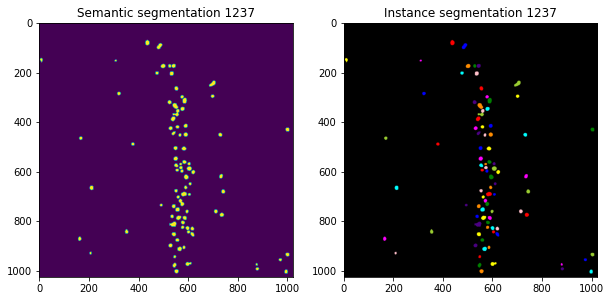

1377.tif


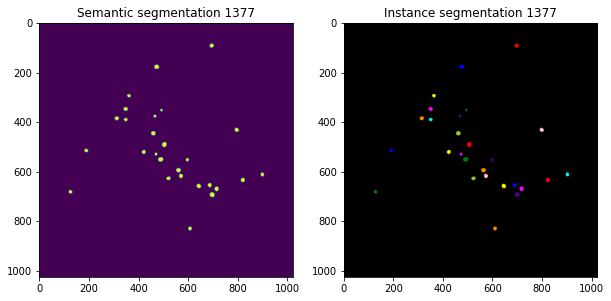

1582.tif


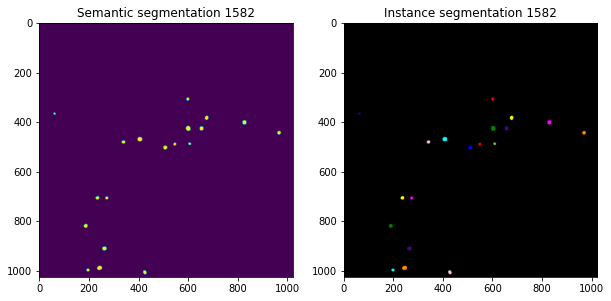

1385.tif


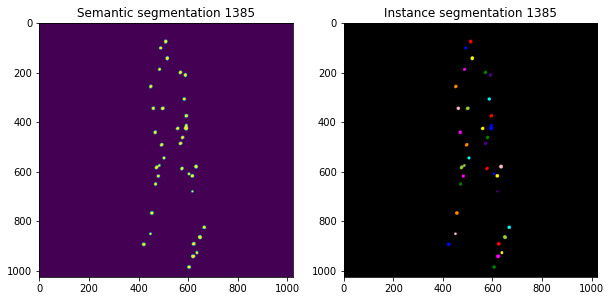

1283.tif


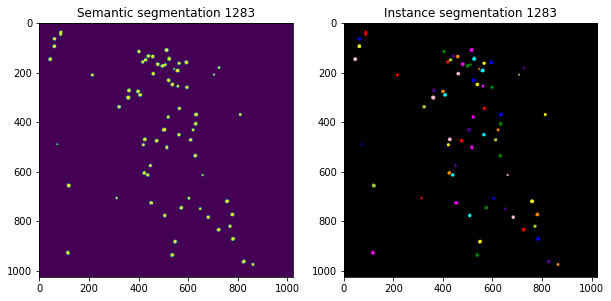

1418.tif


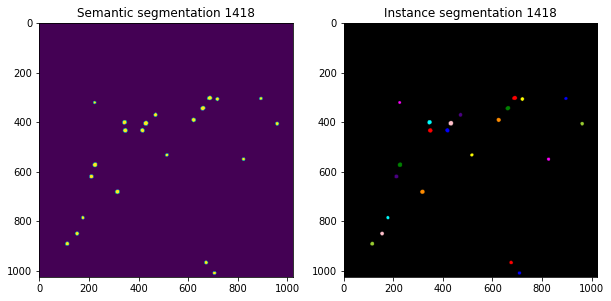

1599.tif


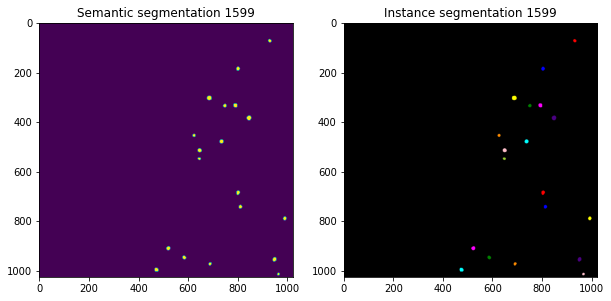

1444.tif


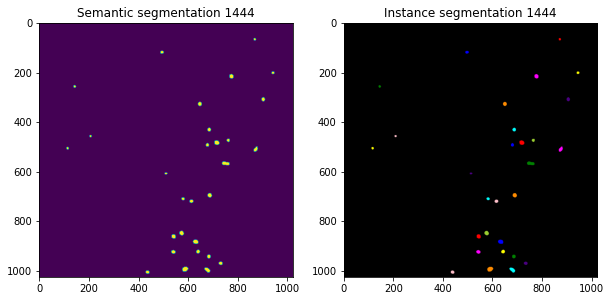

MAX_C2-CD5 II BLA 20X BLA 1-2.tif


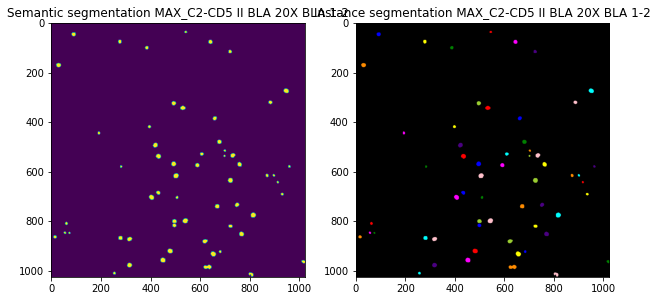

In [6]:
test_image_path = path/'test'/'images'
test_files = [x for x in test_image_path.iterdir() if not x.name.startswith('.')]
test_images = list(tifffile.imread(test_files))
    
for model_type in ['cellpose_ensemble']: # , 'cellpose_single', 'cellpose'

    if model_type=='cellpose':
        print(model_type)
        model_type2=pretrained_dict[DATASET]
        model = models.Cellpose(gpu=use_GPU, model_type=model_type2)

        masks, flows, styles, diams = model.eval(test_images, 
                                          diameter=diam_dict[DATASET], 
                                          channels=channels
                                        )

    else:
        print('Using fine tuned model')
        pretrained_models = [x.as_posix() for x in (TRAINED_MODEL_PATH/f'{SEED+1}'/DATASET/'models').iterdir() 
                             if not x.name.endswith('_size.npy') and not x.name.startswith('.')]
        if model_type=='cellpose_single': pretrained_models = pretrained_models[:1]
        print(pretrained_models)
        model = models.CellposeModel(gpu=use_GPU, 
                                     pretrained_model=pretrained_models,
                                     diam_mean=mean_diam_dict[DATASET], 
                                    )
        
        masks, flows, styles = model.eval(test_images, 
                                          diameter=diam_dict[DATASET], 
                                          channels=channels
                                        )


    
    prediction_path = OUTPUT_PATH/DATASET/model_type
    for i, f in enumerate(test_files):
        print(f.name)
        idx = f.stem
        label_msk = masks[i]
        # Save semantic segmentation prediction
        masks_path = prediction_path/'masks'
        masks_path.mkdir(parents=True, exist_ok=True)
        imageio.imwrite(masks_path/f'{idx}.png', ((label_msk>0)*255).astype('uint8'))

        # Save instance segmentation prediction
        instance_masks_path = prediction_path/'instance_masks'
        instance_masks_path.mkdir(exist_ok=True)
        tifffile.imwrite(instance_masks_path/f'{idx}.tif', label_msk.astype('int16'), compress=6)

        # Plot
        fig, axs = plt.subplots(ncols=2, figsize=(10,5))
        axs[0].imshow(label_msk>0)
        axs[0].set_title(f'Semantic segmentation {idx}')
        axs[1].imshow(label2rgb(label_msk, bg_label=0))
        axs[1].set_title(f'Instance segmentation {idx}')
        plt.show()

1237.tif
1377.tif
1582.tif
1385.tif
1283.tif
1418.tif
1599.tif
1444.tif
MAX_C2-CD5 II BLA 20X BLA 1-2.tif


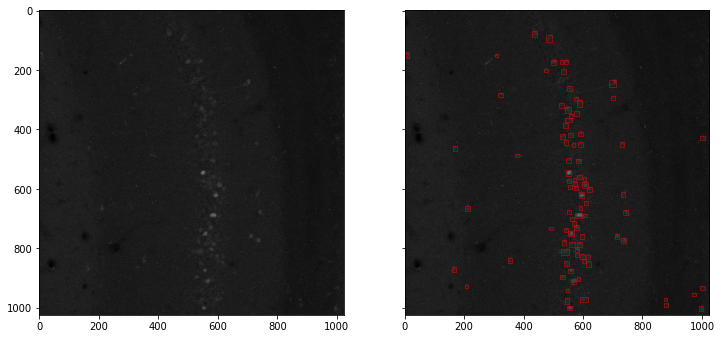

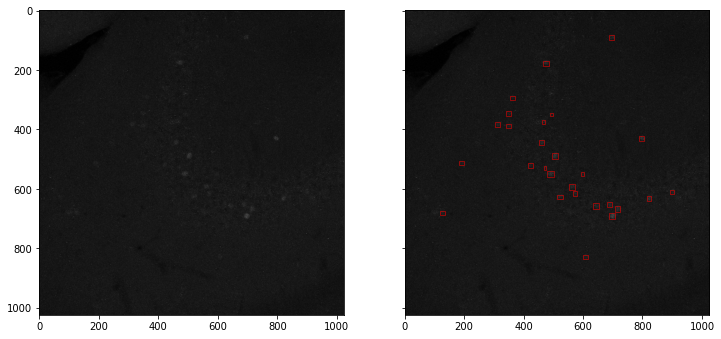

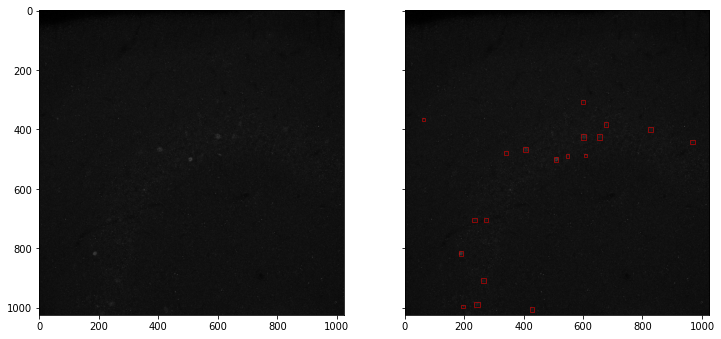

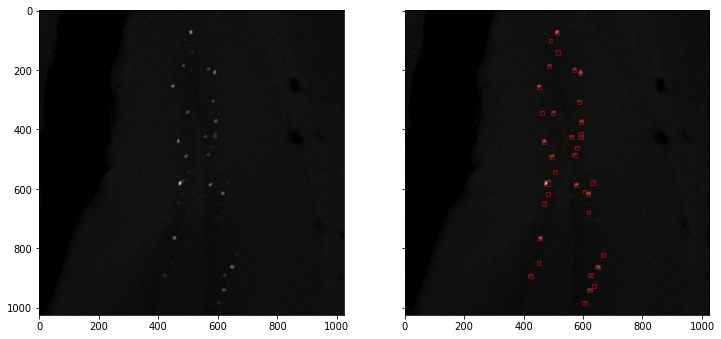

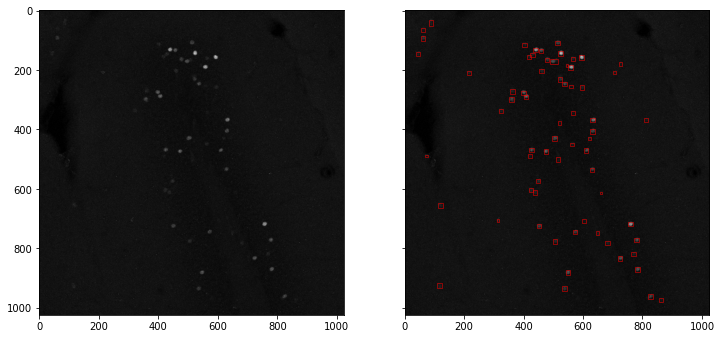

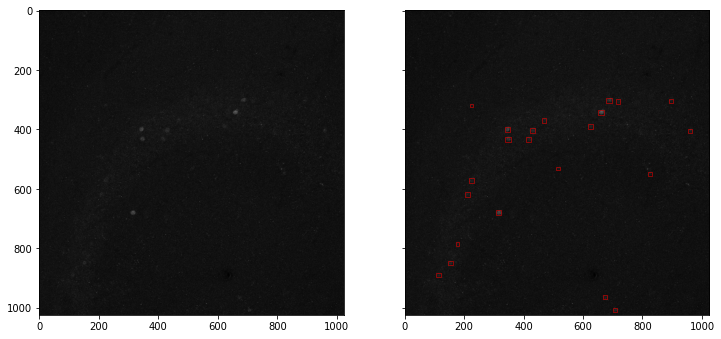

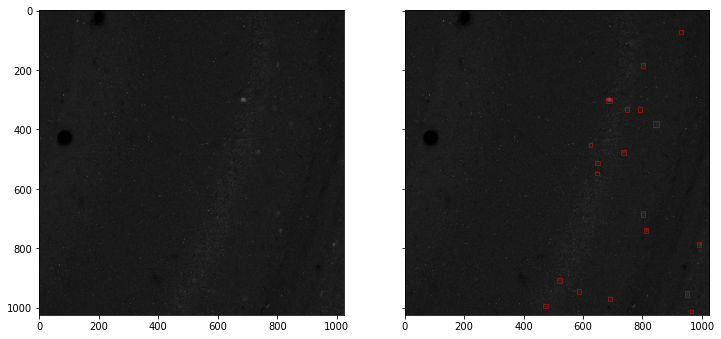

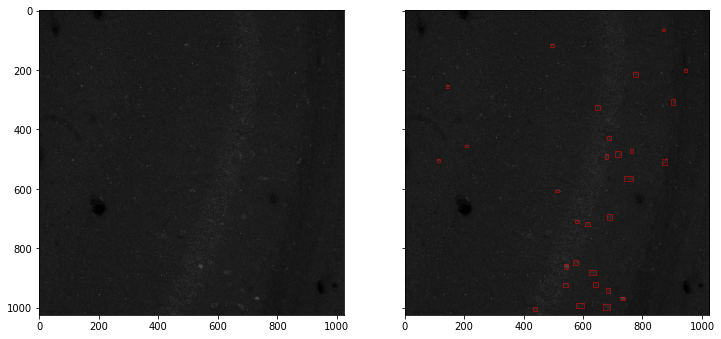

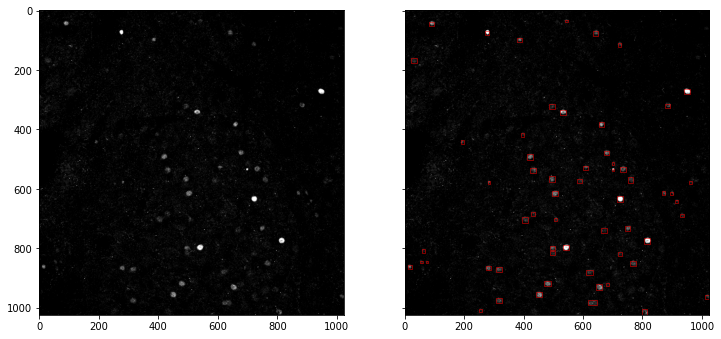

In [7]:
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import watershed
import matplotlib.patches as mpatches
import pandas as pd

for i, f in enumerate(test_files):
      print(f.name)
      idx = f.stem
      label_msk = masks[i]
      image = imageio.imread(test_files[i])
      sample_l = label(label_msk)
      sample_rp = regionprops(sample_l)

      fig, ax = plt.subplots(ncols = 2, figsize=(12, 12), sharex = True, sharey = True)
      ax[0].imshow(image, cmap = 'gray')
      ax[1].imshow(image, cmap = 'gray')
      
      for region in regionprops(sample_l):
        # take regions with large enough areas
        # if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=0.5)
        ax[1].add_patch(rect)
        axs[1].set_title(f'Instance segmentation {idx}')
        # ax[1].set_axis_off()

        sample_regionprops = regionprops_table(sample_l, image, 
                         properties = ['label', 
                                       'area',
                                       'centroid',
                                       'perimeter', 
                                       'equivalent_diameter', 
                                       'mean_intensity', 
                                       'solidity'])
        
        summary = pd.DataFrame(sample_regionprops)
        summary.to_csv(instance_masks_path/f'{idx}.csv', index = False)

